# STAT115 Homework 1

- Author: Matthew Feng
- Date: January 9,  2021

# Part 1: Introduction to R

## Problem 1: Installation

### Installing packages

In [2]:
# install.packages("BiocManager")
# install.packages(c("ggplot2", "dplyr", "tidyr", "HistData", "mvtnorm", "reticulate"));

# BiocManager::install();
# BiocManager::install("sva", update=FALSE);
# BiocManager::valid()

### Load packages

In [3]:
# these packages are needed for HW2
# affy and affyPLM are needed to read the microarray data and run RMA

library(sva);        # for batch effect correction. Contains ComBat and sva.
library(ggplot2);    # for plotting
library(dplyr);      # for data manipulation
library(reticulate); # needed to run python in Rstudio

# these next two are not essential to this course
library(mvtnorm);    # need this to simulate data from multivariate normal
library(HistData);   # need this for data

Loading required package: mgcv

Loading required package: nlme

This is mgcv 1.8-38. For overview type 'help("mgcv-package")'.

Loading required package: genefilter

Loading required package: BiocParallel


Attaching package: ‘dplyr’


The following object is masked from ‘package:nlme’:

    collapse


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘HistData’


The following object is masked from ‘package:nlme’:

    Wheat




## Problem 2: Getting help

You can use the `mean()` function to compute the mean of a vector like so:

In [4]:
x1 <- c(1:10, 50)
mean(x1)

[1] 9.545455

However, this does not work if the vector contains NAs:

In [5]:
x1_na <- c(1:10, 50, NA)
mean(x1_na)

[1] NA

**a.** Please use R documentation to find the mean after excluding NA's. (Hint: `?mean`)

In [8]:
?base::mean

In [6]:
mean(x1_na, na.rm=TRUE)

[1] 9.545455

# Part II: Data Manipulation

## Problem 3: Basic selection

In this question, we will practice data manipulation using a dataset
collected by Francis Galton in 1886 on the heights of parents and their
children. This is a very famous dataset, and Galton used it to come up
with regression and correlation.

The data is available as `GaltonFamilies` in the `HistData` package.
Here, we load the data and show the first few rows. To find out more
information about the dataset, use `?GaltonFamilies`.

In [7]:
data(GaltonFamilies)
head(GaltonFamilies)

,family,father,mother,midparentHeight,children,childNum,gender,childHeight
,<fct>,<dbl>,<dbl>,<dbl>,<int>,<int>,<fct>,<dbl>
1,001,78.5,67.0,75.43,4,1,male,73.2
2,001,78.5,67.0,75.43,4,2,female,69.2
3,001,78.5,67.0,75.43,4,3,female,69.0
4,001,78.5,67.0,75.43,4,4,female,69.0
5,002,75.5,66.5,73.66,4,1,male,73.5
6,002,75.5,66.5,73.66,4,2,male,72.5


**a.** Please report the height of the 10th child in the dataset.

In [9]:
# your R code here
print(GaltonFamilies[10, "childHeight"])

[1] 68


**b.** What is the breakdown of male and female children in the dataset?

In [13]:
# your R code here
table = table(GaltonFamilies$gender)
print(table)


female   male 
   453    481 


**c.** How many observations (number of rows) are in Galton's dataset? Please answer this question without consulting the R help.

In [14]:
# your R code here
nrow(GaltonFamilies)

[1] 934

**d.** What is the mean height for the 1st child in each family?

In [15]:
# your R code here
firstChild = filter(GaltonFamilies, childNum == 1)
mean(firstChild$childHeight)

[1] 69.82098

**e.** Create a table showing the mean height for male and female children.

In [16]:
# your R code here
GaltonFamilies %>% group_by(gender) %>% summarize(mean_height = mean(childHeight))

gender,mean_height
<fct>,<dbl>
female,64.10397
male,69.23410


**f.** What was the average number of children each family had?

In [22]:
# your R code here
GaltonFamilies %>% distinct(family, .keep_all=TRUE) %>% summarize(avg_num_children = mean(children))

avg_num_children
<dbl>
4.556098


**g.** Convert the children's heights from inches to centimeters and store it in a column called `childHeight_cm` in the `GaltonFamilies` dataset. Show the first few rows of this dataset.

In [23]:
# your R code here
INCH_TO_CM = 2.54
GaltonFamilies_metric = mutate(GaltonFamilies, childHeight_cm = childHeight * INCH_TO_CM)
head(GaltonFamilies_metric)

,family,father,mother,midparentHeight,children,childNum,gender,childHeight,childHeight_cm
,<fct>,<dbl>,<dbl>,<dbl>,<int>,<int>,<fct>,<dbl>,<dbl>
1,001,78.5,67.0,75.43,4,1,male,73.2,185.928
2,001,78.5,67.0,75.43,4,2,female,69.2,175.768
3,001,78.5,67.0,75.43,4,3,female,69.0,175.260
4,001,78.5,67.0,75.43,4,4,female,69.0,175.260
5,002,75.5,66.5,73.66,4,1,male,73.5,186.690
6,002,75.5,66.5,73.66,4,2,male,72.5,184.150


## Problem 4: Spurious correlation

In [24]:
# set seed for reproducibility
set.seed(1234)
N <- 25
ngroups <- 100000
sim_data <- data.frame(group = rep(1:ngroups, each = N),
                       X = rnorm(N * ngroups),
                       Y = rnorm(N * ngroups))

In the code above, we generate `ngroups` groups of `N` observations
each. In each group, we have X and Y, where X and Y are independent
normally distributed data and have 0 correlation.

**a.** Find the correlation between X and Y for each group, and display
the highest correlations.

Hint: since the data is quite large and your code might take a few
moments to run, you can test your code on a subset of the data first, e.g. you can take the first 100 groups like so:

```r
filter(sim_data, group %in% 1:100)
```

In general, this is good practice whenever you have a large dataset:
If you are writing new code and it takes a while to run on the whole
dataset, get it to work on a subset first. By running on a subset, you
can iterate faster.

However, please do run your final code on the whole dataset.

In [36]:
# your code here
find_correlations = function(dataset) {
    corr = dataset %>% group_by(group) %>% summarize(corr = cor(X, Y))
    corr
}
corr = find_correlations(sim_data)

In [38]:
head(arrange(corr, desc(corr)))

group,corr
<int>,<dbl>
99655,0.8014245
98068,0.7820605
66510,0.7457852
46164,0.7193613
30063,0.7185124
63287,0.7154357


**b.** The highest correlation is around 0.8. Can you explain why we see
such a high correlation when X and Y are supposed to be independent and
thus uncorrelated?

> Because we generated so many (100,000) groups with relatively few observations in each group, it is likely that some will have high correlations (either positive or negative).

# Part III: Plotting

## Problem 5

**a.** Show a plot of the data for the group that had the highest correlation you found in Problem 4.

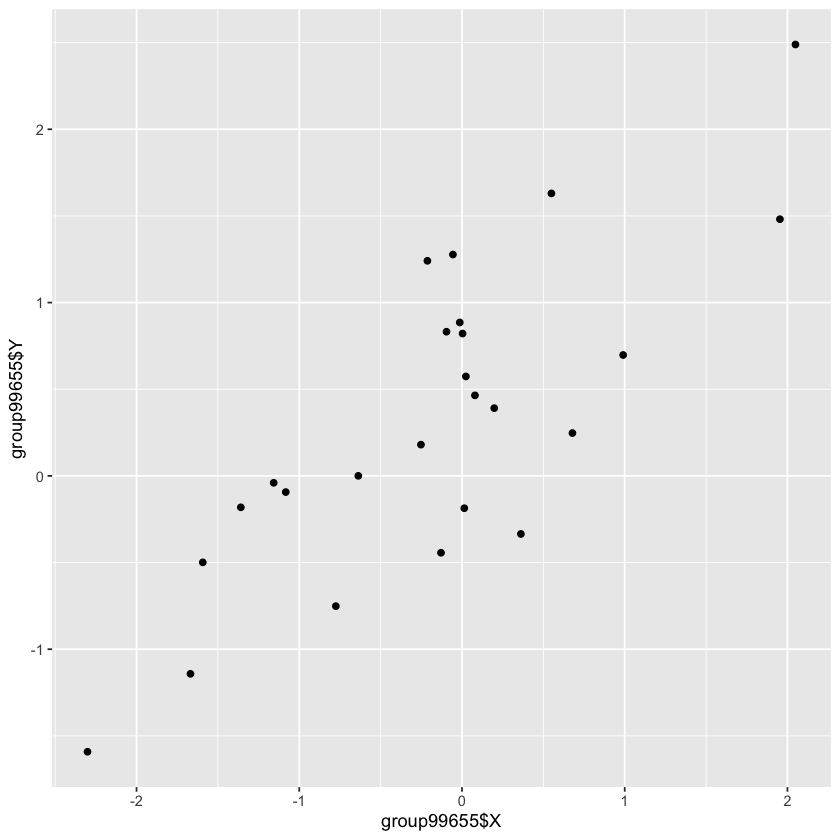

In [42]:
# your code here
group99655 = sim_data %>% filter(group == 99655)
qplot(group99655$X, group99655$Y)

## Problem 6

We generate some sample data below. The data is numeric, and has 3
columns: X, Y, Z.

In [43]:
N <- 100
Sigma <- matrix(c(1, 0.75, 0.75, 1), nrow = 2, ncol = 2) * 1.5
means <- list(c(11, 3), c(9, 5), c(7, 7), c(5, 9), c(3, 11))
dat <- lapply(means, function(mu)
  rmvnorm(N, mu, Sigma))
dat <- as.data.frame(Reduce(rbind, dat)) %>%
  mutate(Z = as.character(rep(seq_along(means), each = N)))
names(dat) <- c("X", "Y", "Z")

**a.** Compute the overall correlation between X and Y.

In [46]:
# your code here
corrXY = cor(dat$X, dat$Y)
print(corrXY)

[1] -0.7362015


**b.** Make a plot showing the relationship between X and Y. Comment on
the correlation that you see.

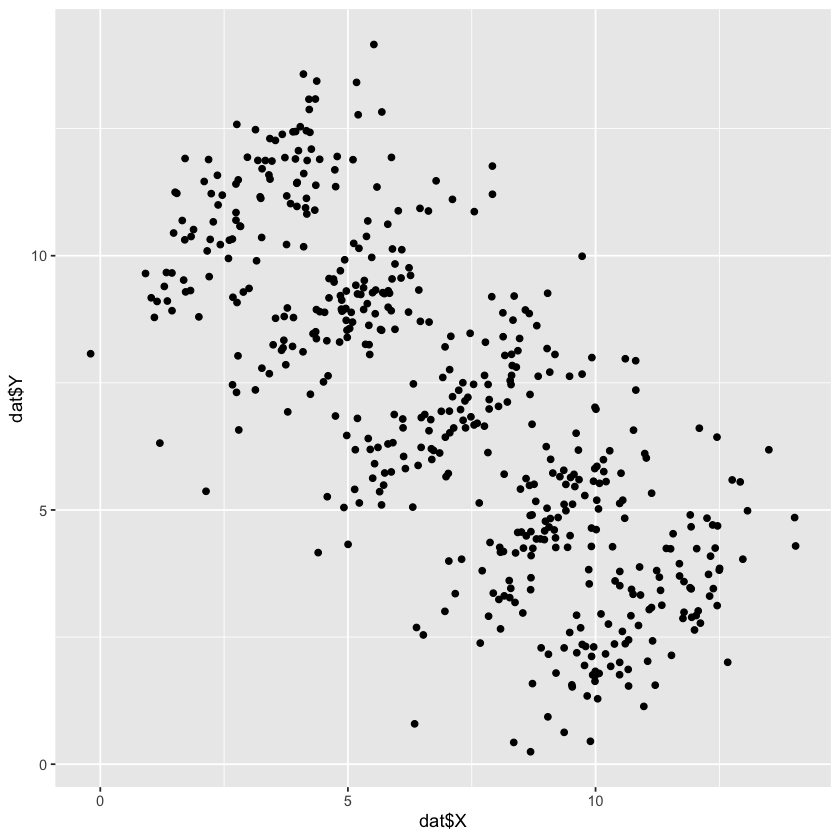

In [47]:
# your code here
qplot(dat$X, dat$Y)

> There is a negative correlation overall, but there are five clusters within the overall dataset, each with a positive correlation.

**c.** Compute the correlations between X and Y for each level of Z.

In [48]:
# your code here
corrXY_given_Z = dat %>% group_by(Z) %>% summarize(corr = cor(X, Y))
print(corrXY_given_Z)

# A tibble: 5 × 2
  Z      corr
  <chr> <dbl>
1 1     0.743
2 2     0.756
3 3     0.772
4 4     0.785
5 5     0.730


**d.** Make a plot showing the relationship between X and Y, but this time, color the points using the value of Z. Comment on the result, especially any differences between this plot and the previous plot.

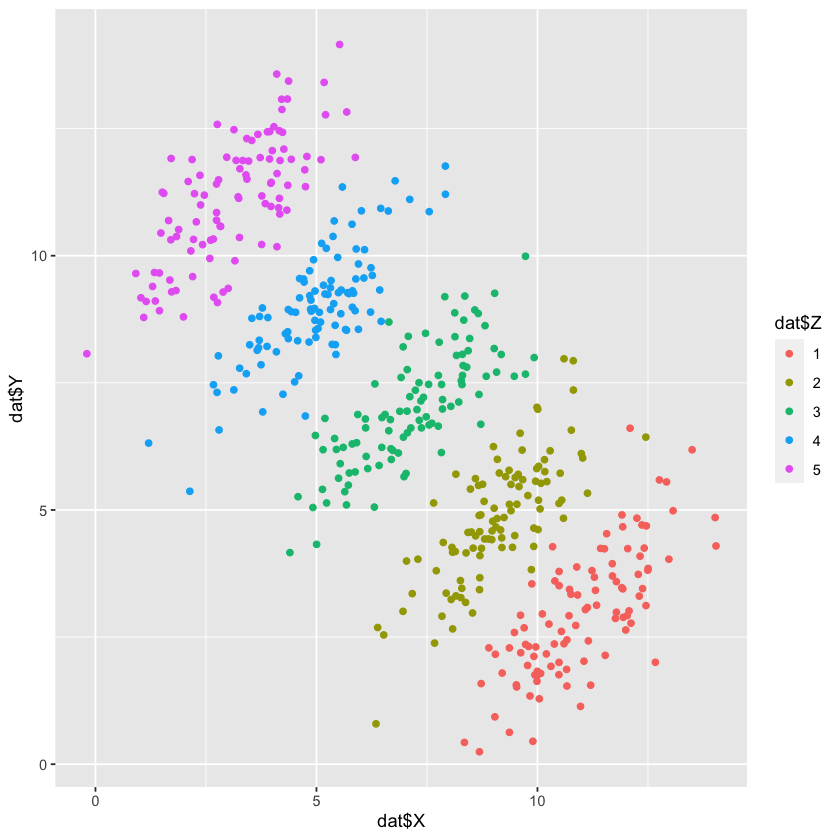

In [50]:
# your code here
qplot(dat$X, dat$Y, color=dat$Z)

> With the coloring scheme, it makes it very obvious that there is a positive correlation between X and Y within every level of Z, with a decreasing overall correlation between X and mean(Y) as Z increases.

# Part IV: Bash practice

## Problem 7: Bash practice on Odyssey

Please answer the following question using bash commands and include those in 
your answer. Data are available at `/n/stat115/2020/HW1/public_MC3.maf`

Mutation Annotation Format ([MAF](https://docs.gdc.cancer.gov/Data/File_Formats/MAF_Format/)) 
is a tab-delimited text file with aggregated mutation information. 
MC3.maf `/n/stat115/2020/HW1/public_MC3.maf` is a curated list of [somatic mutation](https://www.britannica.com/science/somatic-mutation) 
occured in many patients with different types of cancers from TCGA.

Since a complete MAF file contains far more information than we need, 
in this problem we will focus on part of it.

```
Chromosome  Start_Position  Hugo_Symbol Variant_Classification
10          123810032       TACC2       Missense_Mutation
10          133967449       JAKMIP3     Silent
11          124489539       PANX3       Missense_Mutation
11          47380512        SPI1        Missense_Mutation
11          89868837        NAALAD2     Missense_Mutation
11          92570936        FAT3        Silent
12          107371855       MTERFD3     Missense_Mutation
12          108012011       BTBD11      Missense_Mutation
12          117768962       NOS1        5'Flank
```

In  `/n/stats115/2020/HW1/MC3/public_MC3.maf`, `Chromosome` and `Start_Position` 
together specifies the genomics location where a location has happened. 
`Hogo_symbol` is the overlapping gene of that location, and 
`Variant_Classification` specifies how it influences downstream biological 
processes, e.g. transcription and translation.

Please include your bash commands and the full output from bash console 
with text answer to the questions.

**a.** How many lines are there in this file? How many times does the "KRAS" gene emerge?

**b.** How many unique `Variant_Classification` are there in the MAF? Please count occurence of each type and sort them. Which one is the most frequent?

**c.** What are the top FIVE most frequent genes? Please provide the bash command and equivalent Python command. If you are a PI looking for a gene to investigate (you need to find a gene with potentially better biological significance), which gene out of the top 5 would you choose? Why?

**d.** Write a bash program that determines whether a user-input year ([YYYY]) is a leap year or not (all years that are multiples of four. If the year is centennial and not divisible by 400, then it is not a leap year). The user input can be either positional or interactive. Please include the content of your shell script here and test on 1900/2000/2002, does your code run as expected?

# Part V. High throughput sequencing read mapping

We will give you a simple example to test high throughput sequencing
alignment for RNA-seq data. Normally for paired-end sequencing data,
each sample will have two separate FASTQ files, with line-by-line
correspondence to the two reads from the same fragment. Read mapping
could take a long time, so we have created just two FASTQ files of one
RNA-seq sample with only 3M fragments (2 * 3M reads) for you to run STAR
instead of the full data. The files are located at
`/n/stat115/2020/HW1`. The mapping will generate one single output
file. Make sure to use the right parameters for single-end (SE) vs
paired-end (PE) modes in BWA and STAR.

Please include the commands that you used to run BWA and STAR in your
answers.

## Problem 8: BWA

**a.** Use BWA (Li & Durbin, Bioinformatics 2009) to map the reads to the Hg38 version of the reference genome, available on Odyssey at `/n/stat115/HW2_2019/bwa_hg38_index/hg38.fasta`.

In `/n/stat115/HW1_2020/BWA/loop`, you are provided with three `.fastq` files with following structure (`A_l` and `A_r` are paired sequencing reads from sample_A). Write a for loop in bash to align reads to the reference using BWA PE mode and geneterate output in SAM format.

How many rows are in each output `.sam` files? Use SAMTools on the output to find out how many reads are mappable and uniquely mappable (please also calculate the ratio). Please include full samtools output and text answer.

## Problem 9: STAR Alignment

**a.** Use STAR (Dobin et al, Bioinformatics 2012) to map the reads to the
reference genome, available on Odyssey at
`/n/stat115/HW1_2020/STARIndex`. Use the paired-end alignment mode and
generate the output in SAM format. Please include full STAR report.  

How many reads are mappable and how many are uniquely mappable?

**b.** If you are getting a different number of mappable fragments between BWA and STAR on the same data, why?

# Part VII: Dynamic programming with Python

## Problem 10

Given a list of finite integer numbers, write a python script to maximize $Z$, where $Z$ is the sum of the numbers from location $X$ to location $Y$ on this list. Be aware, your algorithm should look at each number ONLY ONCE from left to right. Your script should return three values: the starting index location $X$, the ending index location $Y$, and $Z$, the sum of numbers between index $X$ and $Y$ (inclusive).

For example, if `A=[-2, 1, 7, -4, 5, 2, -3, -6, 4, 3, -8, -1, 6, -7, -9, -5]`, your program should return (`start_index = 1`, `end_index = 5`, `sum = 11`) corresponding to `[1, 7, -4, 5, 2]`.

Please test your program with this example and see if you can get the correct numbers.

Hint: Consider dynamic programming.